In [1]:
from utils.read_datasetBreakfast import load_data, read_mapping_dict
import os
import numpy as np


COMP_PATH = ''

''' 
training to load train set
test to load test set
'''
#split = 'training'
split = 'test'
test_split  =  os.path.join(COMP_PATH, 'splits/test.split1.bundle') #Test Split
GT_folder   =  os.path.join(COMP_PATH, 'groundTruth/') #Ground Truth Labels for each training video 
DATA_folder =  os.path.join(COMP_PATH, 'Data/') #Frame I3D features for all videos
mapping_loc =  os.path.join(COMP_PATH, 'splits/mapping_bf.txt') 

actions_dict = read_mapping_dict(mapping_loc)

data_feat = load_data( test_split, actions_dict, GT_folder, DATA_folder, datatype = split) #G

In [13]:
segment_idx = []
with open("./utils/test_segment.txt") as f:
    while True:
        line = f.readline()
        if not line:
            break
        segment_idx.append(line[:-1].split(" "))

[['30', '150', '428', '575', '705'], ['38', '199', '378', '775'], ['385', '599', '1382', '4007', '4123'], ['54', '229', '514', '754', '1024'], ['483', '548', '703', '853', '2633', '2960', '3310', '3740', '4110', '4200', '4375'], ['190', '260', '552', '652', '1664', '1763', '2264', '2780', '2939'], ['89', '239', '919', '1174'], ['30', '150', '428', '575', '705'], ['38', '199', '378', '775'], ['54', '229', '514', '754', '1024'], ['190', '260', '552', '652', '1664', '1763', '2264', '2780', '2939'], ['89', '239', '919', '1174'], ['30', '150', '428', '575', '705'], ['38', '199', '378', '775'], ['385', '599', '1382', '4007', '4123'], ['54', '229', '514', '754', '1024'], ['483', '548', '703', '853', '2633', '2960', '3310', '3740', '4110', '4200', '4375'], ['190', '260', '552', '652', '1664', '1763', '2264', '2780', '2939'], ['89', '239', '919', '1174'], ['30', '150', '428', '575', '705'], ['38', '199', '378', '775'], ['385', '599', '1382', '4007', '4123'], ['54', '229', '514', '754', '1024'],

In [18]:
data_feat_seg = []
for i in range(len(data_feat)):
    for j in range(len(segment_idx[i])-1):
        data_feat_seg.append(data_feat[i][int(segment_idx[i][j]):int(segment_idx[i][j+1])])

In [21]:
print(data_feat[0].shape)
print(len(data_feat_seg))
print(data_feat_seg[0].shape)

torch.Size([832, 400])
1284
torch.Size([120, 400])


In [8]:
import torch.utils.data as tud
class VideoTestDataset(tud.Dataset):
    def __init__(self, videos):
        super(VideoTestDataset, self).__init__()
        self.videos = videos

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video = self.videos[idx]
        return video

In [22]:
import torch.nn.utils as u
import torch
from Dataset.VideoDataset import VideoDataset
import torch.utils.data as tud
from Models.LSTM import LSTM_Model
from matplotlib import pyplot as plt 
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

model = torch.load("./trained/lstm/lstm_200.pkl", map_location=torch.device("cpu"))
model.eval()

dataset = VideoTestDataset(data_feat_seg)
dataloader = tud.DataLoader(dataset, shuffle=False)
predict_labels = []
with torch.no_grad():
    for in_feature in dataloader:
        packed_input = u.rnn.pack_padded_sequence(in_feature, torch.LongTensor([in_feature.shape[1]]),batch_first=True, enforce_sorted=False)
        output = model(packed_input)
        label_predict = torch.max(output, 1)[1]
        predict_labels.append(label_predict.item())
        
#predict_labels = np.asarray(predict_labels)

E:\Study\Anaconda\lib\site-packages\torch\serialization.py:452: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
E:\Study\Anaconda\lib\site-packages\torch\serialization.py:452: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [24]:
path = './results/lstm/test_result.csv'
f = open(path, 'w+')
f.write('Id,Category\n')

counter = 0
for i in predict_labels:
        f.write(f'{counter},{i}\n')
        counter += 1
f.close()

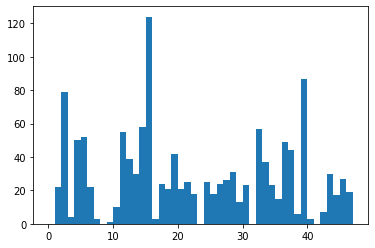

In [23]:
test = np.asarray(predict_labels)
plt.hist(test, bins=range(0,48))
plt.show()

In [41]:
train_split  =  os.path.join(COMP_PATH, 'splits/dev_train.split1.bundle') #Test Split
data_feat, data_labels = load_data( train_split, actions_dict, GT_folder, DATA_folder, datatype = split) #G

Finish Load the Training data and labels!!!


In [52]:
import random

def balance_data(data_feat, data_labels):
    label_dict = {}
    for i in range(len(data_labels)):
        if data_labels[i] not in label_dict.keys():
            label_dict[data_labels[i]] = [data_feat[i]]
        else:
            label_dict[data_labels[i]].append(data_feat[i])
    class_num = len(label_dict.keys())
    avg_len = int(len(data_labels) / class_num)

    new_data_feat = []
    new_data_labels = []
    for k in label_dict.keys():
        if len(label_dict[k]) < avg_len:
            multiplier = int(avg_len/len(label_dict[k])) + 1
            label_dict[k] = label_dict[k] * multiplier
        random.shuffle(label_dict[k])
        new_data_feat.extend(label_dict[k][:avg_len])
        new_data_labels.extend([k] * avg_len)
    return new_data_feat, new_data_labels

859
820
820
torch.Size([181, 400])


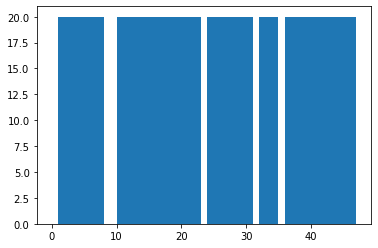

In [55]:
#import utils.balance_data as b
test1, test2 = balance_data(data_feat, data_labels)
print(len(data_feat))
print(len(test1))
print(len(test2))
print(test1[0].shape)
abc = np.asarray(test2)
plt.hist(abc, bins=range(0,48))
plt.show()

In [79]:
import torch.nn.utils as u
print(data_feat[0].shape)
print(data_feat[1].shape)
print(data_feat[2].shape)
a= [data_feat[0], data_feat[1], data_feat[2]]
b = u.rnn.pad_sequence(a, batch_first=True)
print(b.shape)
print(b[0].shape)
print(b[0])

torch.Size([260, 400])
torch.Size([205, 400])
torch.Size([328, 400])
torch.Size([3, 328, 400])
torch.Size([328, 400])
tensor([[-18.6309,   5.0323,  -3.4568,  ...,  -2.5323,  -4.2312,  -7.8478],
        [-20.1714,   6.4342,  -2.4734,  ...,  -1.8793,  -4.3813, -10.2211],
        [-19.4268,   6.6107,  -2.6361,  ...,  -1.9418,  -4.8028, -10.2391],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],
       dtype=torch.float64)
